In [249]:
import lightkurve as lk
import astropy.table as astab
import pandas as pd
import astropy
from astropy.coordinates import SkyCoord
from astropy import units as u
import matplotlib.pyplot as plt
from tqdm import tqdm
%pylab inline
pylab.rcParams['figure.figsize'] = (16, 8)
import warnings
import astropy.table as astab

warnings.filterwarnings("ignore",message='ERROR:lightkurve.search')
# warnings.filterwarnings('ignore', message=f'No data found for target')
print(astropy.__version__)

import pymc3 as pm
import pymc3_ext as pmx
import aesara_theano_fallback.tensor as tt
from celerite2.theano import terms, GaussianProcess
import exoplanet as xo

import arviz as az
from corner import corner

from scipy.signal import savgol_filter

# %matplotlib widget
dd = "/Users/kjaehnig/CCA_work/GAT/"

Populating the interactive namespace from numpy and matplotlib
4.3.1


In [70]:
hq_jk_allstar_tess_edr3 = astab.Table.read(dd+'dr17_joker/unimodal_joker_sample_joined_w_tess_edr3.fits', format='fits')

In [71]:
calibverr = astab.Table.read(dd+'dr17_joker/allVisit-dr17-synspec-calib-verr.fits', format='fits', hdu=1)
print(calibverr.info)
sysapodat = astab.Table.read(dd+"dr17_joker/tic20215452_apogee_visit_data.fits", hdu=1, format='fits')
print(len(sysapodat))
sysapodat = astab.join(sysapodat, calibverr, keys=('VISIT_ID','VISIT_ID'))
print(len(sysapodat))

<Table length=2318773>
   name     dtype 
---------- -------
  VISIT_ID bytes64
CALIB_VERR float64

26
26


In [72]:
fit,ax = plt.subplots(nrows=2)
ax[0].scatter(sysapodat['JD']%3.06, sysapodat['VHELIO'])
ax[1].scatter(sysapodat['JD']%0.59, sysapodat['VHELIO'])

Canvas(toolbar=Toolbar(toolitems=[('Home', 'Reset original view', 'home', 'home'), ('Back', 'Back to previous …

In [202]:
target_tic = 'TIC 20215452'

target_lk = lk.search_lightcurve(target_tic,
             mission='TESS',
            cadence='short',
            author='SPOC'
             )
print(target_lk)
unpro_lks = target_lk.download_all(quality_bitmask='hardest').stitch()
lks = target_lk.download_all(quality_bitmask='hardest').stitch(
        ).flatten(window_length=201)#.remove_outliers(sigma_lower=10**9, sigma_upper=.5)

jk_row = hq_jk_allstar_tess_edr3[hq_jk_allstar_tess_edr3['ID']==int(target_tic.split(' ')[1])][0]
periods = np.linspace(max(0.34,jk_row['MAP_P']-jk_row['MAP_P_err']), 
                    min(jk_row['MAP_P']+0.5*jk_row['MAP_P'],jk_row['MAP_P']+jk_row['MAP_P_err'])
                      ,1000)
joker_per = jk_row['MAP_P']
print(joker_per, jk_row['MAP_P_err'])



SearchResult containing 1 data products.

 #     mission     year author exptime target_name distance
                                  s                 arcsec 
--- -------------- ---- ------ ------- ----------- --------
  0 TESS Sector 24 2020   SPOC     120    20215452      0.0


3.067790985107422 8.047527194932069e-05


In [236]:
lks = lks.remove_nans()  #[lks.remove_nans()]
lks = lks.remove_outliers(sigma_lower=10**6)
period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
star1_bls = lks.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = 2000, duration=np.linspace(0.005,0.09,100))
star1_per = star1_bls.period_at_max_power
star1_t0 = star1_bls.transit_time_at_max_power
star1_dur = star1_bls.duration_at_max_power
print(star1_per, star1_t0, star1_dur)


0.5953533130814371 d 1956.3036026548211 0.043000000000000003 d


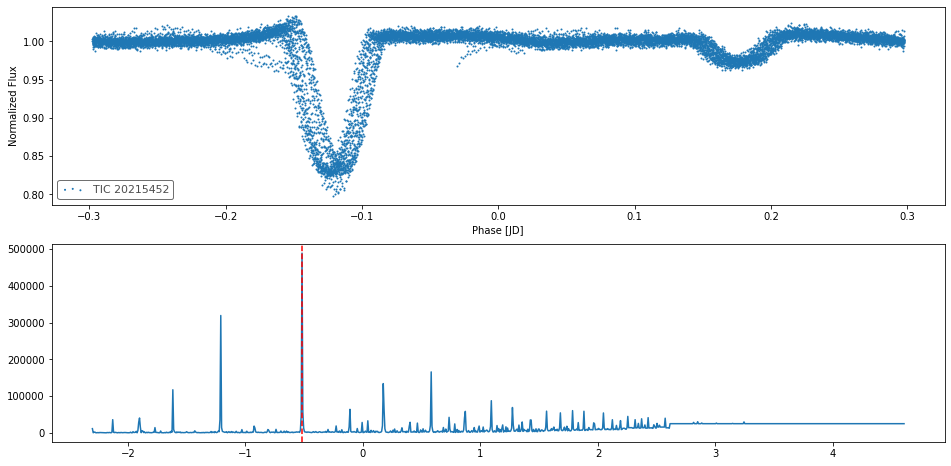

In [237]:
fig,ax = plt.subplots(nrows=2)
lks.fold(period=star1_per, epoch_time=star1_t0-10).scatter(ax = ax[0])
ax[1].plot(np.log(period_grid), star1_bls.power)
ax[1].axvline(np.log(star1_per.value), ls='--',c='red')

#### manual smoothing and outlier removal per the RV-TRANSIT model example page

In [83]:
def interactive_lightcurve_fold_flattening_widget(lks, 
                                                  per0 = star1_per,
                                                  t0=star1_t0,
                                                  wl0=101
                                                 ):
    
    fig = plt.figure(figsize=(8,4),constrained_layout=False)
    ax_grid = GridSpec(nrows=100, ncols=100)
    ax_wl = fig.add_subplot(ax_grid[-5:,:])
    ax_per = fig.add_subplot(ax_grid[-15:-10,:])
    ax_t0 = fig.add_subplot(ax_grid[-25:-20, :])
    ax_plt = fig.add_subplot(ax_grid[:-30,:])
    
    
    wl_slider = Slider(
                ax = ax_wl,
                label = r"$L_{window}$",
                valmin = 3,
                valmax = 3*wl0,
                valinit = wl0,
                orientation='horizontal'
    )
    
    per_slider = Slider(
                ax = ax_per,
                label = r'$Period\ [d]$',
                valmin = np.exp(np.log(0.001)),
                valmax = np.exp(np.log(5.*per0)),
                valinit = per0,
                orientation='horizontal'
    )
    
    t0_slider = Slider(
                ax = ax_t0,
                label = r'$t_{0}$',
                valmin = min(lks.time.value),
                valmax = max(lks.time.value),
                valinit = t0,
                orientation = 'horizontal'
    )
    
    def update_lks_plot(val):
        updated_lks = lks.flatten(window_length = wl_slider.val)
        updated_lks.fold(
                normalize_phase=True, 
                period=per_slider.val, 
                epoch_time=t0_slider.val).scatter(
                                            ax = ax_plt
                                                )
        fig.canvas.draw_idle()
    
    wl_slider.on_changed(update_lks_plot)
    per_slider.on_changed(update_lks_plot)
    t0_slider.on_changed(update_lks_plot)
    
    plt.show()

In [207]:
lks_flat = unpro_lks.flatten(window_length=wl)
ini_data = lks_flat.fold(normalize_phase=True, period=star1_per, epoch_time=star1_t0-10)
lks_flat.interact_bls(maximum_period=10)

In [241]:
star1_mask = lks.create_transit_mask(period=star1_per.value, 
                                     duration=star1_dur.value, 
                                     transit_time=star1_t0.value)

In [242]:
period_grid = np.exp(np.linspace(np.log(0.1), np.log(100),1000))
star2_lks = lks[~star1_mask]
star2_bls = star2_lks.to_periodogram('bls',
                                period=period_grid,
                                frequency_factor = 2000, duration=np.linspace(0.005,0.09,100))
star2_per = star2_bls.period_at_max_power
star2_t0 = star2_bls.transit_time_at_max_power
star2_dur = star2_bls.duration_at_max_power


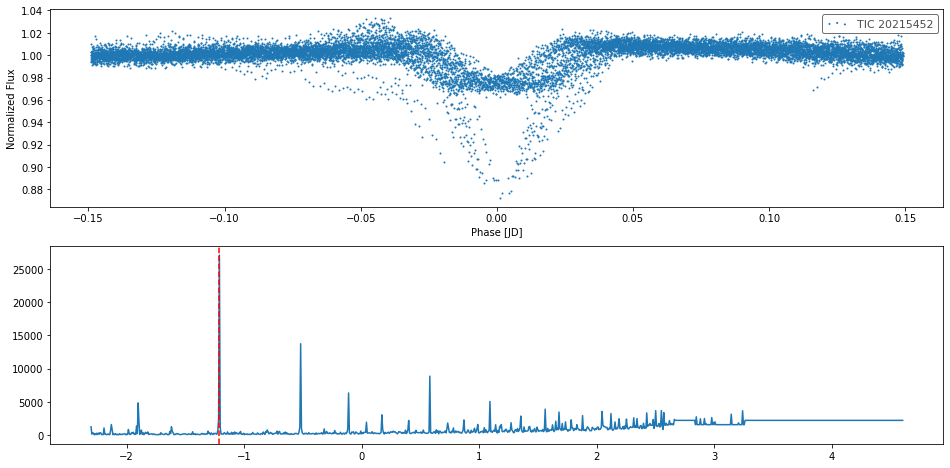

In [247]:
fig,ax = plt.subplots(nrows=2)
star2_lks.fold(period=star2_per, epoch_time=star2_t0).scatter(ax = ax[0])
ax[1].plot(np.log(period_grid), star2_bls.power)
ax[1].axvline(np.log(star2_per.value), ls='--',c='red')

In [245]:
print(star2_per, star2_t0, star2_dur)

0.29817722900196725 d 1955.9811026548211 0.042 d


<AxesSubplot:xlabel='Phase [JD]', ylabel='Normalized Flux'>

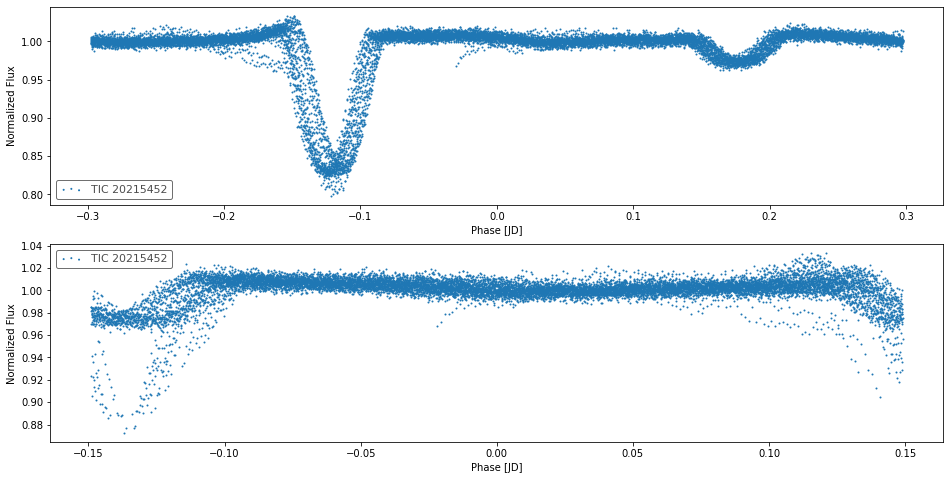

In [246]:
fig,ax = plt.subplots(nrows=2)
lks.fold(normalize_phase=False,epoch_time=star1_t0-10 , period=star1_per).scatter(ax=ax[0])
lks[~star1_mask].fold(normalize_phase=False, epoch_time=star2_t0-10, period=star2_per).scatter(ax=ax[1])


# RV-Transit Model construction

In [ ]:


# These arrays are used as the times/phases where the models are
# evaluated at higher resolution for plotting purposes
t_rv = np.linspace(x_rv.min() - 5, x_rv.max() + 5, 500)
phase_lc = np.linspace(-0.3, 0.3, 100)

msini = 1.0 * u.M_sun  ## just to keep it simple 

def build_model(mask=None, start=None):
    if mask is None:
        mask = np.ones(len(x), dtype=bool)
    with pm.Model() as model:

        # Parameters for the stellar properties
        mean = pm.Normal("mean", mu=0.0, sd=10.0)
        u_star = xo.QuadLimbDark("u_star")
        star = xo.LimbDarkLightCurve(u_star)
        BoundedNormal = pm.Bound(pm.Normal, lower=0, upper=3)
        m_star = BoundedNormal(
            "m_star", mu=M_star_petigura[0], sd=M_star_petigura[1]
        )
        r_star = BoundedNormal(
            "r_star", mu=R_star_petigura[0], sd=R_star_petigura[1]
        )

        # Orbital parameters for the planets
        t0 = pm.Normal("t0", mu=np.array(t0s), sd=1, shape=2)
        log_m_pl = pm.Normal("log_m_pl", mu=np.log(msini.value), sd=1, shape=2)
        log_period = pm.Normal("log_period", mu=np.log(periods), sd=1, shape=2)

        # Fit in terms of transit depth (assuming b<1)
        b = pm.Uniform("b", lower=0, upper=1, shape=2)
        log_depth = pm.Normal(
            "log_depth", mu=np.log(depths), sigma=2.0, shape=2
        )
        ror = pm.Deterministic(
            "ror",
            star.get_ror_from_approx_transit_depth(
                1e-3 * tt.exp(log_depth), b
            ),
        )
        r_pl = pm.Deterministic("r_pl", ror * r_star)

        m_pl = pm.Deterministic("m_pl", tt.exp(log_m_pl))
        period = pm.Deterministic("period", tt.exp(log_period))

        ecs = pmx.UnitDisk("ecs", shape=(2, 2), testval=0.01 * np.ones((2, 2)))
        ecc = pm.Deterministic("ecc", tt.sum(ecs ** 2, axis=0))
        omega = pm.Deterministic("omega", tt.arctan2(ecs[1], ecs[0]))
        xo.eccentricity.vaneylen19(
            "ecc_prior", multi=True, shape=2, fixed=True, observed=ecc
        )

        # RV jitter & a quadratic RV trend
        log_sigma_rv = pm.Normal(
            "log_sigma_rv", mu=np.log(np.median(yerr_rv)), sd=5
        )
        trend = pm.Normal(
            "trend", mu=0, sd=10.0 ** -np.arange(3)[::-1], shape=3
        )

        # Transit jitter & GP parameters
        log_sigma_lc = pm.Normal(
            "log_sigma_lc", mu=np.log(np.std(y[mask])), sd=10
        )
        log_rho_gp = pm.Normal("log_rho_gp", mu=0.0, sd=10)
        log_sigma_gp = pm.Normal(
            "log_sigma_gp", mu=np.log(np.std(y[mask])), sd=10
        )

        # Orbit models
        orbit = xo.orbits.KeplerianOrbit(
            r_star=r_star,
            m_star=m_star,
            period=period,
            t0=t0,
            b=b,
            m_planet=xo.units.with_unit(m_pl, msini.unit),
            ecc=ecc,
            omega=omega,
        )

        # Compute the model light curve
        light_curves = (
            star.get_light_curve(orbit=orbit, r=r_pl, t=x[mask], texp=texp)
            * 1e3
        )
        light_curve = pm.math.sum(light_curves, axis=-1) + mean
        resid = y[mask] - light_curve

        # GP model for the light curve
        kernel = terms.SHOTerm(
            sigma=tt.exp(log_sigma_gp),
            rho=tt.exp(log_rho_gp),
            Q=1 / np.sqrt(2),
        )
        gp = GaussianProcess(kernel, t=x[mask], yerr=tt.exp(log_sigma_lc))
        gp.marginal("transit_obs", observed=resid)

        # And then include the RVs as in the RV tutorial
        x_rv_ref = 0.5 * (x_rv.min() + x_rv.max())

        def get_rv_model(t, name=""):
            # First the RVs induced by the planets
            vrad = orbit.get_radial_velocity(t)
            pm.Deterministic("vrad" + name, vrad)

            # Define the background model
            A = np.vander(t - x_rv_ref, 3)
            bkg = pm.Deterministic("bkg" + name, tt.dot(A, trend))

            # Sum over planets and add the background to get the full model
            return pm.Deterministic(
                "rv_model" + name, tt.sum(vrad, axis=-1) + bkg
            )

        # Define the model
        rv_model = get_rv_model(x_rv)
        get_rv_model(t_rv, name="_pred")

        # The likelihood for the RVs
        err = tt.sqrt(yerr_rv ** 2 + tt.exp(2 * log_sigma_rv))
        pm.Normal("obs", mu=rv_model, sd=err, observed=y_rv)

        # Compute and save the phased light curve models
        pm.Deterministic(
            "lc_pred",
            1e3
            * tt.stack(
                [
                    star.get_light_curve(
                        orbit=orbit, r=r_pl, t=t0[n] + phase_lc, texp=texp
                    )[..., n]
                    for n in range(2)
                ],
                axis=-1,
            ),
        )

        # Fit for the maximum a posteriori parameters, I've found that I can get
        # a better solution by trying different combinations of parameters in turn
        if start is None:
            start = model.test_point
        map_soln = pmx.optimize(start=start, vars=[trend])
        map_soln = pmx.optimize(start=map_soln, vars=[log_sigma_lc])
        map_soln = pmx.optimize(start=map_soln, vars=[log_depth, b])
        map_soln = pmx.optimize(start=map_soln, vars=[log_period, t0])
        map_soln = pmx.optimize(
            start=map_soln, vars=[log_sigma_lc, log_sigma_gp]
        )
        map_soln = pmx.optimize(start=map_soln, vars=[log_rho_gp])
        map_soln = pmx.optimize(start=map_soln)

        extras = dict(
            zip(
                ["light_curves", "gp_pred"],
                pmx.eval_in_model([light_curves, gp.predict(resid)], map_soln),
            )
        )

    return model, map_soln, extras


model0, map_soln0, extras0 = build_model()